<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/10_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow & Milestone project 3: BitPredict

>**Note -** This is not financial advice.

Links:
* [All resources](https://github.com/mrdbourke/tensorflow-deep-learning)
* [book version of actual code](https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/)

We will write tensorflow code to predict the price on bitcoin based on the historical price of bitcoin.

## Get the data

We're going to be using historical price data of Bitcoin to try and predict the future price

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-10-06 12:36:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2022-10-06 12:36:32 (65.8 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [ ]:
import pandas as pd

df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # Parse date column and tell pandas that we wante the date column as index

In [ ]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like larger datasets. However a smaller number of samples is something we will often run into.

>**Note -** The *seasonality* of a time series dataset is referred as the number of samples per year. So for our bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day, meaning we get 365 samples per year.

In [ ]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "price"})

In [ ]:
bitcoin_prices.head()

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


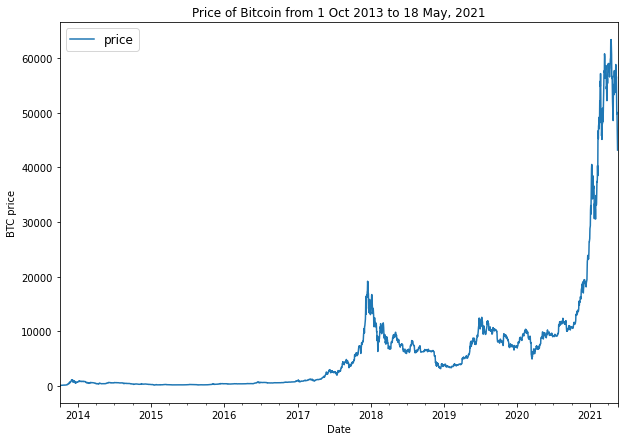

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7));
plt.ylabel("BTC price");
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May, 2021", fontsize=12);
plt.legend(fontsize=12);


## Importing time series data with Python's CSV module


In [ ]:
import csv
import numpy as np
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (gets rid of headers)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View the first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

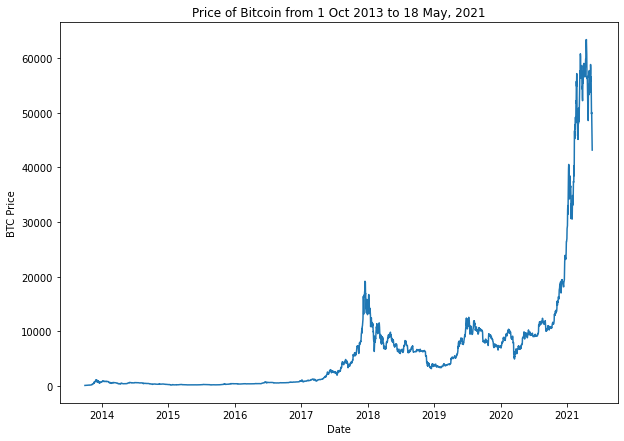

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.plot(timesteps,btc_price);
plt.ylabel("BTC Price");
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May, 2021", fontsize=12);
plt.xlabel("Date");

## Creating train and test sets the wrong way 

In [ ]:
# get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.price.to_numpy()

In [ ]:
timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets for time series data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates,
                                                    prices, # BTC prices
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

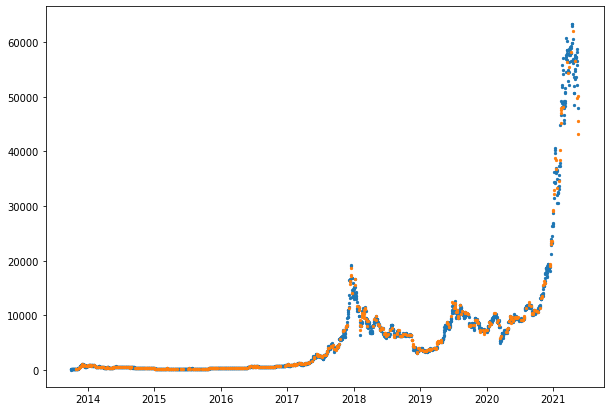

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="train data");
plt.scatter(X_test, y_test, s=5, label="test data");

## Create train & test sets for time series (the right way) 

The standard we choose is 80% train, 20% test. It is up to us to decide, depending on the amount of data we have available.

In [ ]:
split_size = int(0.8 * len(prices))

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)
y_train[:5]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866])

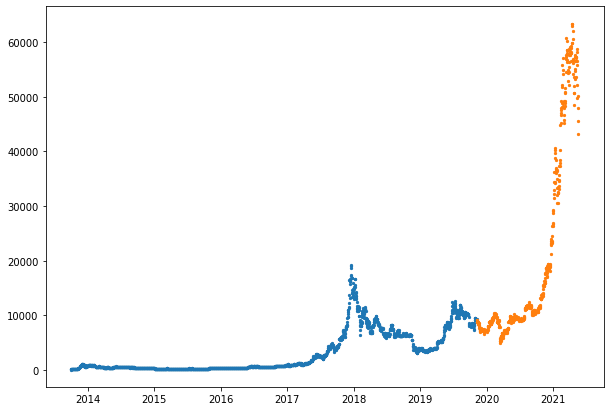

In [ ]:
# Plot correctly made splits
fig = plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="train data");
plt.scatter(X_test, y_test, s=5, label="test data");

## Create a plotting function

Typing plotting code is tedious, let's functionalize it.

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format, start=0, end=None, label=None):
  """
  plots values taken at a range of timesteps

  Parameters
  ----------

  timesteps: array of timestep values
  values: array of values across time
  format: style of plot, default "."
  start: where to start the plot
  end: end of timestep
  label: label to show on plot about values, default None
  """

  # Plot series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)


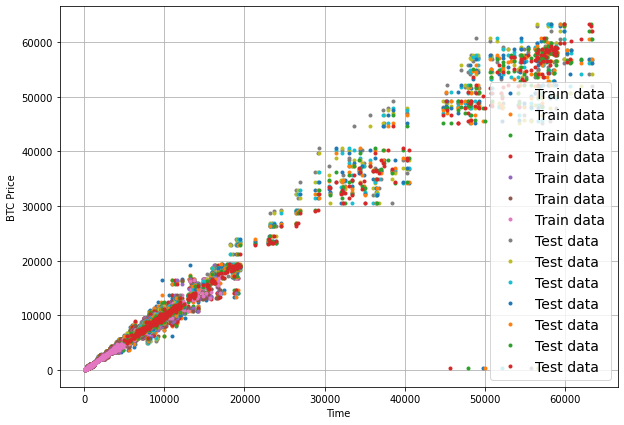

In [ ]:
# Test our plotting function
plt.figure(figsize=(10,7));
plot_time_series(timesteps=X_train, values=y_train, format=".", label="Train data");
plot_time_series(timesteps=X_test, values=y_test, format=".", label="Test data");


## Modelling Experiments

With our bitcoin historical data, we will define now a series of modelling experiments and see which model performs best:

<br>

Experiment | Model 
-----------|-------
0 | Naive model (baseline)
1 | Dense model (`horizon = 1, window = 7`)
2 | Same as model 1 (`horizon = 1, window = 30`)
3 | Same as model 1 (`horizon = 7, window = 30`)
4 | Conv1D
5 | LSTM
6 | Same as model 1 (but with multivariate data)
7 | N-BEATS algorithm
8 | Ensemble (multiple models stacked together)
9 | Future prediction model
10 | Same as model 1 (but with Turkiye data introduced)

<br>

Terms to be familiar: 
* **Horizon -** Number of timesteps into the future we're going to predict.
* **Window size -** Number of timesteps we're going to use to predict the **horizon**.

<br>

>**Note -** Generally we will be working with `horizon = 1`, and `window = 7`.

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-h}$$

where $\hat{y}_{t}$ is the forecast, and $\hat{y}_{t-h}$ is the value at the previous timestep (horizon) 

<br>

> The prediction at timestep t (y-hat) is equal to the value at timestep t - h (previous timestep).

In [ ]:
y_test[:10], y_test[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361, 43144.47129086]))

In [ ]:
# Create a naive forecast 
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

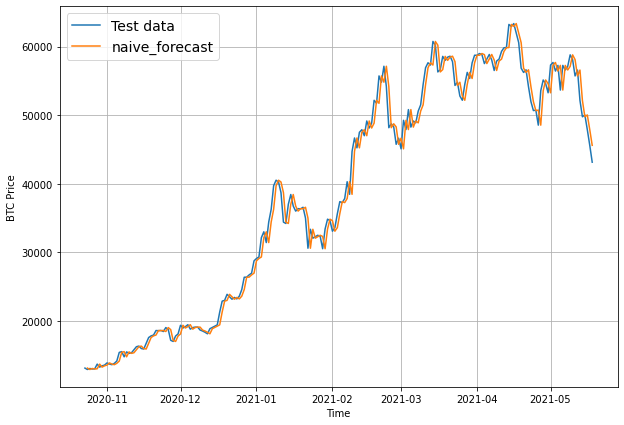

In [ ]:
# plot naive forecast
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train, values=y_train, label="Train data", format=".");
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=350, format="-");
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="naive_forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We are predicting a number, means we have a regression problem. Knowing so, we know the pool of evaluation metrics we can choose. 
The main thing we are evaluating here is: **how do our model's forecasts (`y_pred`) compare against true values (`y_true`)?**
A table containing important information on evaluation metrics is shown below: 

<br>

Metric name | Metric formula &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  | TensorFlow code | When to use
------------|:--------------:|:---------------:|------------
Mean absolute error (MAE) | $$MAE = \frac{\sum_{i=1}^n | y_{i} - x_{i}|}{n} $$ | `tf.keras.losses.MAE` </br> or </br>`tf.metrics.mean_absolute_error()` | As a great starter metric for </br> any regression problem.
Mean square error (MSE) | $$MSE = \frac{1}{n}\sum_{i=1}^n (Y_{i} - \hat{Y}_{i})^2$$ | `tf.keras.losses.MSE()` </br> or </br> `tf.metrics.mean_squared_error()` | When larger errors are more significant than smaller errors.
Root mean squared error (RMSE) | $$RMSE = \sqrt{MSE}$$ | `tf.sqrt(tf.metrics.mean_square_error())` | Similar to MSE but as interpretable as MAE (RMSE is in same units as target).
(Simetric) Mean absolute </br> percentage error |$$sMAPE = mean (|100 e_{t}/y_{t}|)$$ | `tf.keras.metrics.mean_absolute_percentage_error()`| Recommend not to use by Hyndman & Koehler.
Mean absolute scaled error (MASE) | $$q_{j}=\frac{e_j}{\frac{1}{T-1}\sum_{t=2}^T|y_{t} - y_{t-1}|}$$ | Custom </br> or </br> See sktime's `mase_loss()` | A scaled error > 1 if the forecast is worse than the </br> naive and < 1 if the forecast is better than the naive 


For all of these metrics, the lower the values are, the better.




In [ ]:
import tensorflow as tf

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Impelment MASE (assuming no seasonality of data)
  """

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)

  # OUr seasonality is 1 day (hence the shift of 1)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [ ]:
def evaluate_preds(y_true, y_pred):
  """
  Returns MAE, MSE, RMSE, MAPE and MASE as a dictionary   
  """

  # Make sure float32 datatype (for metrics calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mape":mape.numpy(),
          "mase": mase.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy()}

Now we try our function, let's see how it works:

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Other models we can use for baseline and for actual forecast.

In this notebook, we've focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models we may want to experiment with, which you can find [here](https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts)

## Format data part 2: Windowing our dataset

<br>

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week:

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
len(y_train)

2229

In [ ]:
# What we want to do with our bitcoin data
print(f"We want to use: {btc_price[:7]}\nto predict: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795]
to predict: 123.033


Let's set up some global variables for window and horizon size

> **Remember:** *Window size (input)* is the number of time steps of historical data used to predict the horizon -> *data*. *Horizon* is the number of time steps to predict into the future -> *label*

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

Now we create a function to label windowed data

In [ ]:
tf.expand_dims(tf.range(8) +1, axis=0).numpy()

array([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=int32)

In [ ]:
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window,).numpy()} ->, Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] ->, Label: 8


Can we predict the next **horizon** given the past **window**?

More precisely...

Can we predict the *price of bitcoin tomorrow* given the past *week of prices*?

We've got a way to label our windowed data. However, this only works on a small scale. We need a way to do the above across our entire dataset. We could do this with a for loop, however, for large time series, that'd be quite slow. To speed this up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Our function will:

1. Create a window step of specific window size (e.g. `[0, 1, 2, 3, 4, 5, 6]`)
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:

```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5 ,6 ,7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

> **Resource -** The function we're about to create has been adapted from [this article](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5)

In [ ]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """

  # 1. Create a window of specific window size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  
  # 4. Get labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)


In [ ]:
len(full_windows), len(full_labels)

(2780, 2780)

Let's view the first windows/ labels

In [ ]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [ ]:
prices[-1]

43144.4712908603

> **Note -** There's a function which does similar to the above in `tf.keras.preprocessing`. An extension could be tot try and replicate what we've done using our pre-made function in https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array


```
tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None
)
```

## Turning windows into training and test sets

In [ ]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Make the train/test split
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """

  # This will defauolt to 80% train and 20% test
  split_size = int(len(windows)*(1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels 

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model chekpoint so we can compare apples to apples. More specifically we want to compare each of our model's best performances agains the other model's best performances. For example, if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

From [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint):

```
tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor: str = 'val_loss',
    verbose: int = 0,
    save_best_only: bool = False,
    save_weights_only: bool = False,
    mode: str = 'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
    **kwargs
)
```

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=1,
                                            monitor="val_loss",
                                            save_best_only = True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:

* A single dense layer with 128 hidden units and reLU.
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function 
* Batch size of 128 (previously we've used 32, however because our data has a window size of 7, we are using more batches)
* 100 epochs


> **Note -** All these settings were determined by experimentation. We can further go into optimizing our model through **hyperparameter tuning** (values we set to define). Meanwhile, a model's **parameters** are those values a model learns on its own.


In [ ]:
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name = "model_1_dense")

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 5s - loss: 2111.0571 - mae: 2111.0571 - mse: 9255782.0000
Epoch 1: val_loss improved from inf to 2279.65283, saving model to model_experiments/model_1_dense
18/18 [==============================] - 1s 33ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 348.8859 - mae: 348.8859 - mse: 600802.6250
Epoch 2: val_loss improved from 2279.65283 to 1005.99933, saving model to model_experiments/model_1_dense
18/18 [==============================] - 0s 26ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9993 - val_mae: 1005.9993 - val_mse: 3441833.2500
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 134.4855 - mae: 134.4855 - mse: 70765.6953
Epoch 3: val_loss improved from 1005.99933 to 923.28619, saving model to model_experiments/model_1_dense
1

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mae: 585.9758 - mse: 1197802.1250


[585.9757690429688, 585.9757690429688, 1197802.125]

In [ ]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Rewturns the predictions

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data
  """

  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
       8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)


In [ ]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171743.8,
 'rmse': 1082.4711}

In [ ]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

Let's plot our model 1 predictions


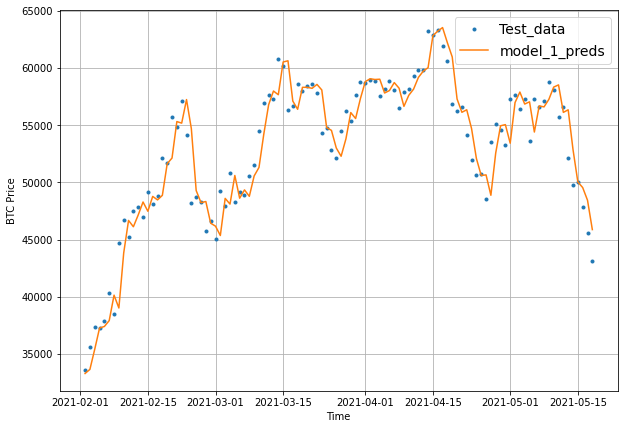

In [ ]:
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test widow offset and idex into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data",
                 format=".")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 start=offset,
                 values=model_1_preds,
                 format="-",
                 label="model_1_preds")

## Model 2
Window size = 30
horizon = 1

In [ ]:
# Define window size and horizon size for model 2
WINDOW_SIZE = 30
HORIZON = 1

windows_model_2, labels_model_2 = make_windows(prices, window_size=WINDOW_SIZE,horizon=HORIZON)
len(windows_model_2), len(labels_model_2)

(2757, 2757)

In [ ]:
# Create train and test windows 
train_windows_2, test_windows_2, train_labels_2, test_labels_2 = make_train_test_splits(windows_model_2, labels_model_2)
len(train_windows_2), len(test_windows_2), len(train_labels_2), len(test_labels_2)

(2205, 552, 2205, 552)

In [ ]:
# Check shape
train_windows_2.shape

(2205, 30)

In [ ]:
# 1. Construct model 2
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear"),
], name = "model_2_dense")

# 2. Compile model 2
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# 3. Fit the model
model_2.fit(x=train_windows_2,
            y=train_labels_2,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows_2, test_labels_2),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 5s - loss: 3486.3677 - mae: 3486.3677 - mse: 30126178.0000
Epoch 1: val_loss improved from inf to 3228.69287, saving model to model_experiments/model_2_dense
18/18 [==============================] - 1s 34ms/step - loss: 1355.7623 - mae: 1355.7623 - mse: 7234175.0000 - val_loss: 3228.6929 - val_mae: 3228.6929 - val_mse: 25149146.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 489.0060 - mae: 489.0060 - mse: 1059863.1250
Epoch 2: val_loss improved from 3228.69287 to 2100.29077, saving model to model_experiments/model_2_dense
18/18 [==============================] - 0s 26ms/step - loss: 440.8260 - mae: 440.8260 - mse: 832458.2500 - val_loss: 2100.2908 - val_mae: 2100.2908 - val_mse: 11994402.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 320.0093 - mae: 320.0093 - mse: 658698.6250
Epoch 3: val_loss improved from 2100.29077 to 1438.40356, saving model to model_experiments/model_2_

In [ ]:
# Evaluate trained model 2
model_2.evaluate(test_windows_2, test_labels_2)

18/18 [==============================] - 0s 2ms/step - loss: 614.1074 - mae: 614.1074 - mse: 1286940.2500


[614.1073608398438, 614.1073608398438, 1286940.25]

In [ ]:
# Load in best performing model
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense/")
model_2.evaluate(test_windows_2, test_labels_2)

18/18 [==============================] - 0s 2ms/step - loss: 608.2637 - mae: 608.2637 - mse: 1268798.3750


[608.2637329101562, 608.2637329101562, 1268798.375]

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2, test_windows_2)

In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels_2), y_pred=model_2_preds)
model_2_results

{'mae': 608.2637,
 'mape': 2.754868,
 'mase': 1.0632509,
 'mse': 1268798.4,
 'rmse': 1126.4094}

In [ ]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171743.8,
 'rmse': 1082.4711}

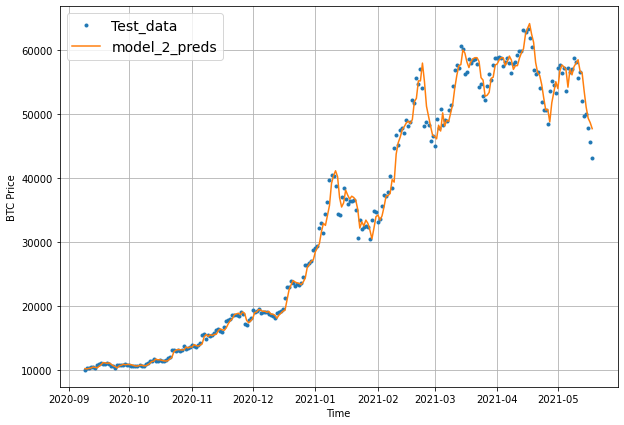

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows_2):], values=test_labels_2[:, 0], start=offset, format=".", label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows_2):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3

Dense, window size of 30, horizon of 7

In [ ]:
# Define window size and horizon size for model 3
WINDOW_SIZE=30
HORIZON=7

windows_model_3, labels_model_3 = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(windows_model_3), len(labels_model_3)

(2751, 2751)

In [ ]:
# Create train and test windows
train_windows_3, test_windows_3, train_labels_3, test_labels_3 = make_train_test_splits(windows_model_3, labels_model_3)

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())


model_3.fit(x=train_windows_3,
            y=train_labels_3,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows_3, test_labels_3),
            callbacks=[create_model_checkpoint(model_3.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 5s - loss: 3423.6187
Epoch 1: val_loss improved from inf to 3088.56128, saving model to model_experiments/model_3_dense
18/18 [==============================] - 1s 30ms/step - loss: 1476.6752 - val_loss: 3088.5613
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 533.6876
Epoch 2: val_loss improved from 3088.56128 to 2462.45483, saving model to model_experiments/model_3_dense
18/18 [==============================] - 0s 25ms/step - loss: 552.8943 - val_loss: 2462.4548
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 439.4582
Epoch 3: val_loss improved from 2462.45483 to 2283.14844, saving model to model_experiments/model_3_dense
18/18 [==============================] - 0s 24ms/step - loss: 435.1978 - val_loss: 2283.1484
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 466.8718
Epoch 4: val_loss improved from 2283.14844 to 1975.12183, saving model to model_experiments/mode

In [ ]:
# Evaluate model 3 
model_3.evaluate(test_windows_3, test_labels_3)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1522


1300.1522216796875

In [ ]:
# Load best version of model 3 and evaluate
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense")
model_3.evaluate(test_windows_3, test_labels_3)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5063


1237.50634765625

In [ ]:
# make predictions with model 3
model_3_preds = make_preds(model_3,
                           input_data=test_windows_3)

In [ ]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.89  , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ]], dtype=float32)>

In [ ]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels_3),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1237.5063,
 'mape': 5.5588784,
 'mase': 2.2020733,
 'mse': 5405198.5,
 'rmse': 1425.7477}

In [ ]:
model_1_results, model_2_results, naive_results

({'mae': 568.9511,
  'mape': 2.5448983,
  'mase': 0.99948955,
  'mse': 1171743.8,
  'rmse': 1082.4711},
 {'mae': 608.2637,
  'mape': 2.754868,
  'mase': 1.0632509,
  'mse': 1268798.4,
  'rmse': 1126.4094},
 {'mae': 567.9802,
  'mape': 2.516525,
  'mase': 0.99957,
  'mse': 1147547.0,
  'rmse': 1071.2362})

We've made and evaluate predictions with `model_3`. Let's visualize our model. Hint, we have 7 size horizon, and not only the timestep in future. 

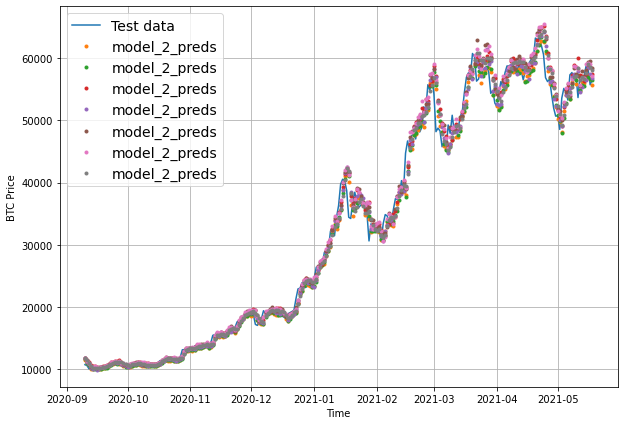

In [ ]:
offset = 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows_3):], values=test_labels_3[:, 0], start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows_3):], values=model_3_preds, start=offset, format=".",label="model_2_preds")

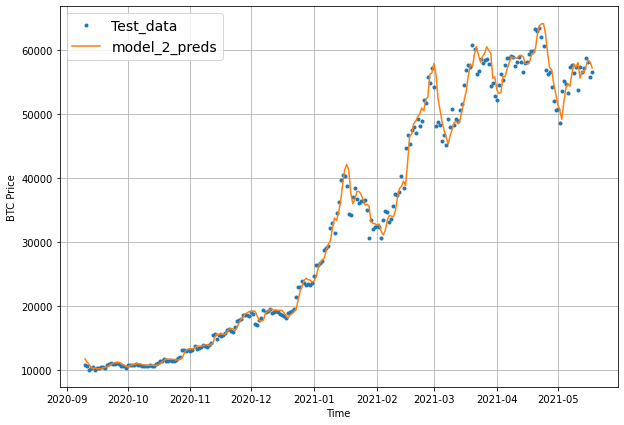

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows_3):], values=test_labels_3[:, 0], start=offset, format=".", label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows_3):], values=tf.reduce_mean(model_3_preds,axis=1), start=offset, format="-", label="model_2_preds")

## Which of our models perform best so far? 

We've trained a few models, and now we will see how they are performing.

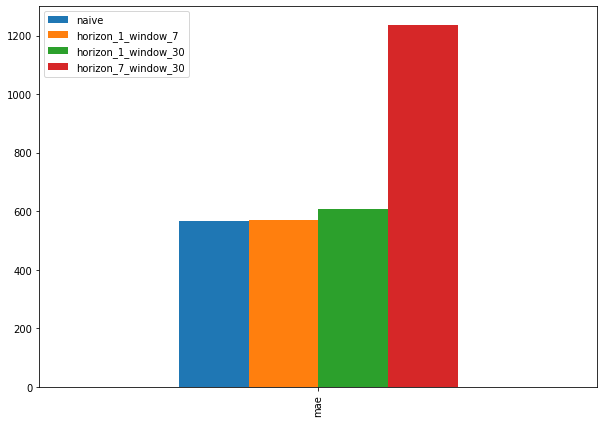

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, 
             index=["mae"]).plot(figsize=(10,7), kind="bar");

>**Note -** One might be wondering, why are the naïve resuts so good? One of the reasons could be due to the presence of autocorrelation in the data. If a time series has autocorrelation it means that the value at $t+1$ is typically close to the value at $t$. In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results. [Read more here](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)

## Model 4: Conv1D




In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

# Create window data
windows_model_4, labels_model_4 = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(windows_model_4), len(labels_model_4)

(2780, 2780)

In [ ]:
# Create train and test windows
train_windows_4, test_windows_4, train_labels_4, test_labels_4 = make_train_test_splits(windows_model_4, labels_model_4)

In [ ]:
train_windows_4.shape, train_labels_4.shape

((2224, 7), (2224, 1))

We need an input shape of `(batch_size, timesteps, input_dim)`. However our data is not in that shape yet

In [ ]:
train_windows_4[0].ndim

1

Before we pass our data to the Conv1D layer, we want to reshape it in order to make sure it works

In [ ]:
x = tf.constant(train_windows_4[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
# We need to add an extra layer to expand input dim (VERY GOOD TIP!)
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # Outputs window size
print(f"Expanded shape {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
    layers.Conv1D(128, kernel_size=WINDOW_SIZE, padding="causal"),
    layers.Dense(HORIZON)
],name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(x=train_windows_4,
            y=train_labels_4,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows_4, test_labels_4),
            callbacks=[create_model_checkpoint(model_4.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1196.3293
Epoch 1: val_loss improved from inf to 2088.85571, saving model to model_experiments/model_4_conv1D
18/18 [==============================] - 2s 72ms/step - loss: 1180.5312 - val_loss: 2088.8557
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 282.5428
Epoch 2: val_loss improved from 2088.85571 to 1159.96545, saving model to model_experiments/model_4_conv1D
18/18 [==============================] - 1s 38ms/step - loss: 281.1686 - val_loss: 1159.9655
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 157.4645
Epoch 3: val_loss did not improve from 1159.96545
18/18 [==============================] - 0s 5ms/step - loss: 186.9816 - val_loss: 1168.7303
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 216.9970
Epoch 4: val_loss improved from 1159.96545 to 922.89020, saving model to model_experiments/model_4_conv1D
18/18 [==============================] - 1s 3

In [ ]:
# Evaluate model 4
model_4.evaluate(test_windows_4,test_labels_4)

18/18 [==============================] - 0s 2ms/step - loss: 563.9799


563.9798583984375

In [ ]:
# Load best performing model 4 and re-evaluate
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1D")
model_4.evaluate(test_windows_4, test_labels_4)

18/18 [==============================] - 0s 2ms/step - loss: 563.9799


563.9798583984375

In [ ]:
model_4_preds = make_preds(model_4, test_windows_4)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8854.327, 8783.963, 9038.658, 8787.148, 8746.151, 8740.773,
       8678.267, 8530.42 , 8462.032, 8530.538], dtype=float32)>

In [ ]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels_4),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 563.9799,
 'mape': 2.5092597,
 'mase': 0.9907565,
 'mse': 1157843.9,
 'rmse': 1076.0315}

In [ ]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data. We use the same data created previously for the Conv1D model (Horizon = 1, window size = 7)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# This time we'll build a LSTM model with the Functional API

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
#x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_5_LSTM")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(x=train_windows_4,
            y=train_labels_4,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows_4,test_labels_4),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 2544.1982 
Epoch 1: val_loss improved from inf to 9222.65234, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 3s 113ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 905.2980 
Epoch 2: val_loss improved from 9222.65234 to 1486.05554, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 99ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
10/18 [===============>..............] - ETA: 0s - loss: 273.4720
Epoch 3: val_loss improved from 1486.05554 to 1298.90845, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 134ms/step - loss: 237.3967 - val_loss: 1298.9084
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 196.5330
Epoch 4: val_loss improved from 1298.90845 to 966.64313, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 100ms/step - loss: 181.9180 - val_loss: 966.6431
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 173.4022
Epoch 5: val_loss did not improve from 966.64313
18/18 [==============================] - 0s 8ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 170.0374
Epoch 6: val_loss improved from 966.64313 to 941.47461, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 99ms/step - loss: 173.5414 - val_loss: 941.4746
Epoch 7/100
11/18 [=================>............] - ETA: 0s - loss: 181.8447
Epoch 7: val_loss improved from 941.47461 to 898.52148, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 170.3566 - val_loss: 898.5215
Epoch 8/100
13/18 [====================>.........] - ETA: 0s - loss: 157.7456
Epoch 8: val_loss did not improve from 898.52148
18/18 [==============================] - 0s 6ms/step - loss: 157.6712 - val_loss: 914.8642
Epoch 9/100
12/18 [===================>..........] - ETA: 0s - loss: 165.4107
Epoch 9: val_loss did not improve from 898.52148
18/18 [==============================] - 0s 6ms/step - loss: 166.5143 - val_loss: 1079.0776
Epoch 10/100
12/18 [===================>..........] - ETA: 0s - loss: 163.3890
Epoch 10: val_loss improved from 898.52148 to 877.16901, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 97ms/step - loss: 162.3369 - val_loss: 877.1690
Epoch 11/100
12/18 [===================>..........] - ETA: 0s - loss: 166.7023
Epoch 11: val_loss did not improve from 877.16901
18/18 [==============================] - 0s 7ms/step - loss: 163.0841 - val_loss: 924.1126
Epoch 12/100
12/18 [===================>..........] - ETA: 0s - loss: 166.9173
Epoch 12: val_loss did not improve from 877.16901
18/18 [==============================] - 0s 6ms/step - loss: 168.5598 - val_loss: 941.6025
Epoch 13/100
11/18 [=================>............] - ETA: 0s - loss: 158.8853
Epoch 13: val_loss did not improve from 877.16901
18/18 [==============================] - 0s 6ms/step - loss: 166.4726 - val_loss: 934.8436
Epoch 14/100
13/18 [====================>.........] - ETA: 0s - loss: 161.4772
Epoch 14: val_loss did not improve from 877.16901
18/18 [==============================] - 0s 6ms/step - loss: 163.9537 - val_loss: 920.2160
Epoch 15/100
12/18 [========

18/18 [==============================] - 2s 96ms/step - loss: 152.9470 - val_loss: 856.2653
Epoch 16/100
11/18 [=================>............] - ETA: 0s - loss: 149.1705
Epoch 16: val_loss did not improve from 856.26526
18/18 [==============================] - 0s 7ms/step - loss: 147.4420 - val_loss: 898.9914
Epoch 17/100
11/18 [=================>............] - ETA: 0s - loss: 156.4332
Epoch 17: val_loss did not improve from 856.26526
18/18 [==============================] - 0s 6ms/step - loss: 151.0533 - val_loss: 943.1418
Epoch 18/100
12/18 [===================>..........] - ETA: 0s - loss: 165.8739
Epoch 18: val_loss did not improve from 856.26526
18/18 [==============================] - 0s 6ms/step - loss: 157.8232 - val_loss: 924.0046
Epoch 19/100
12/18 [===================>..........] - ETA: 0s - loss: 162.2393
Epoch 19: val_loss did not improve from 856.26526
18/18 [==============================] - 0s 6ms/step - loss: 155.9198 - val_loss: 911.4753
Epoch 20/100
12/18 [========

18/18 [==============================] - 2s 98ms/step - loss: 146.8467 - val_loss: 845.2782
Epoch 26/100
12/18 [===================>..........] - ETA: 0s - loss: 146.2229
Epoch 26: val_loss improved from 845.27820 to 818.68073, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 135ms/step - loss: 145.9843 - val_loss: 818.6807
Epoch 27/100
12/18 [===================>..........] - ETA: 0s - loss: 150.8635
Epoch 27: val_loss improved from 818.68073 to 804.32788, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 144.4289 - val_loss: 804.3279
Epoch 28/100
10/18 [===============>..............] - ETA: 0s - loss: 148.9089
Epoch 28: val_loss improved from 804.32788 to 789.08588, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 142.4610 - val_loss: 789.0859
Epoch 29/100
12/18 [===================>..........] - ETA: 0s - loss: 144.1771
Epoch 29: val_loss did not improve from 789.08588
18/18 [==============================] - 0s 7ms/step - loss: 141.8739 - val_loss: 806.6758
Epoch 30/100
12/18 [===================>..........] - ETA: 0s - loss: 139.3476
Epoch 30: val_loss did not improve from 789.08588
18/18 [==============================] - 0s 6ms/step - loss: 142.0521 - val_loss: 794.8836
Epoch 31/100
12/18 [===================>..........] - ETA: 0s - loss: 140.2585
Epoch 31: val_loss improved from 789.08588 to 773.28125, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 99ms/step - loss: 138.4690 - val_loss: 773.2812
Epoch 32/100
12/18 [===================>..........] - ETA: 0s - loss: 139.7511
Epoch 32: val_loss improved from 773.28125 to 772.26245, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 99ms/step - loss: 137.1986 - val_loss: 772.2625
Epoch 33/100
12/18 [===================>..........] - ETA: 0s - loss: 138.2267
Epoch 33: val_loss did not improve from 772.26245
18/18 [==============================] - 0s 7ms/step - loss: 135.9342 - val_loss: 786.4805
Epoch 34/100
13/18 [====================>.........] - ETA: 0s - loss: 142.2633
Epoch 34: val_loss improved from 772.26245 to 744.45062, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 95ms/step - loss: 136.1931 - val_loss: 744.4506
Epoch 35/100
12/18 [===================>..........] - ETA: 0s - loss: 134.0819
Epoch 35: val_loss did not improve from 744.45062
18/18 [==============================] - 0s 7ms/step - loss: 133.4513 - val_loss: 756.2970
Epoch 36/100
12/18 [===================>..........] - ETA: 0s - loss: 132.2655
Epoch 36: val_loss improved from 744.45062 to 735.17291, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 96ms/step - loss: 134.0992 - val_loss: 735.1729
Epoch 37/100
12/18 [===================>..........] - ETA: 0s - loss: 127.8974
Epoch 37: val_loss did not improve from 735.17291
18/18 [==============================] - 0s 6ms/step - loss: 130.6932 - val_loss: 745.9099
Epoch 38/100
12/18 [===================>..........] - ETA: 0s - loss: 133.6792
Epoch 38: val_loss improved from 735.17291 to 717.24976, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 134ms/step - loss: 129.2891 - val_loss: 717.2498
Epoch 39/100
12/18 [===================>..........] - ETA: 0s - loss: 131.6020
Epoch 39: val_loss did not improve from 717.24976
18/18 [==============================] - 0s 6ms/step - loss: 129.6088 - val_loss: 719.0665
Epoch 40/100
11/18 [=================>............] - ETA: 0s - loss: 130.0601
Epoch 40: val_loss did not improve from 717.24976
18/18 [==============================] - 0s 7ms/step - loss: 129.6111 - val_loss: 732.0632
Epoch 41/100
12/18 [===================>..........] - ETA: 0s - loss: 130.4034
Epoch 41: val_loss improved from 717.24976 to 702.93536, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 97ms/step - loss: 127.1393 - val_loss: 702.9354
Epoch 42/100
12/18 [===================>..........] - ETA: 0s - loss: 124.3230
Epoch 42: val_loss improved from 702.93536 to 700.87018, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 101ms/step - loss: 125.6113 - val_loss: 700.8702
Epoch 43/100
12/18 [===================>..........] - ETA: 0s - loss: 121.8617
Epoch 43: val_loss did not improve from 700.87018
18/18 [==============================] - 0s 6ms/step - loss: 125.9959 - val_loss: 704.3682
Epoch 44/100
12/18 [===================>..........] - ETA: 0s - loss: 124.8729
Epoch 44: val_loss improved from 700.87018 to 698.77655, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 125.2241 - val_loss: 698.7766
Epoch 45/100
12/18 [===================>..........] - ETA: 0s - loss: 118.6115
Epoch 45: val_loss improved from 698.77655 to 683.05902, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 122.5007 - val_loss: 683.0590
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 130.0215
Epoch 46: val_loss improved from 683.05902 to 679.18726, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 97ms/step - loss: 124.4726 - val_loss: 679.1873
Epoch 47/100
12/18 [===================>..........] - ETA: 0s - loss: 111.8551
Epoch 47: val_loss did not improve from 679.18726
18/18 [==============================] - 0s 7ms/step - loss: 122.1862 - val_loss: 705.4241
Epoch 48/100
12/18 [===================>..........] - ETA: 0s - loss: 119.4245
Epoch 48: val_loss improved from 679.18726 to 677.07837, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 97ms/step - loss: 122.0458 - val_loss: 677.0784
Epoch 49/100
12/18 [===================>..........] - ETA: 0s - loss: 126.2884
Epoch 49: val_loss improved from 677.07837 to 674.68481, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 133ms/step - loss: 121.1548 - val_loss: 674.6848
Epoch 50/100
12/18 [===================>..........] - ETA: 0s - loss: 120.4853
Epoch 50: val_loss did not improve from 674.68481
18/18 [==============================] - 0s 6ms/step - loss: 122.8890 - val_loss: 691.4816
Epoch 51/100
12/18 [===================>..........] - ETA: 0s - loss: 119.9143
Epoch 51: val_loss did not improve from 674.68481
18/18 [==============================] - 0s 6ms/step - loss: 122.2994 - val_loss: 737.3929
Epoch 52/100
12/18 [===================>..........] - ETA: 0s - loss: 129.3352
Epoch 52: val_loss improved from 674.68481 to 657.23651, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 121.2944 - val_loss: 657.2365
Epoch 53/100
11/18 [=================>............] - ETA: 0s - loss: 118.0734
Epoch 53: val_loss improved from 657.23651 to 652.79700, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 102ms/step - loss: 119.7668 - val_loss: 652.7970
Epoch 54/100
12/18 [===================>..........] - ETA: 0s - loss: 118.0473
Epoch 54: val_loss did not improve from 652.79700
18/18 [==============================] - 0s 6ms/step - loss: 120.1222 - val_loss: 654.4439
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 125.5305
Epoch 55: val_loss improved from 652.79700 to 647.28308, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 99ms/step - loss: 119.2566 - val_loss: 647.2831
Epoch 56/100
12/18 [===================>..........] - ETA: 0s - loss: 121.4963
Epoch 56: val_loss improved from 647.28308 to 643.78082, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 120.0544 - val_loss: 643.7808
Epoch 57/100
12/18 [===================>..........] - ETA: 0s - loss: 127.4654
Epoch 57: val_loss did not improve from 643.78082
18/18 [==============================] - 0s 6ms/step - loss: 123.1243 - val_loss: 671.1797
Epoch 58/100
12/18 [===================>..........] - ETA: 0s - loss: 118.0024
Epoch 58: val_loss improved from 643.78082 to 640.26562, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 96ms/step - loss: 118.4059 - val_loss: 640.2656
Epoch 59/100
12/18 [===================>..........] - ETA: 0s - loss: 114.1296
Epoch 59: val_loss did not improve from 640.26562
18/18 [==============================] - 0s 7ms/step - loss: 117.7119 - val_loss: 645.3837
Epoch 60/100
12/18 [===================>..........] - ETA: 0s - loss: 117.1983
Epoch 60: val_loss improved from 640.26562 to 638.74292, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 118.5346 - val_loss: 638.7429
Epoch 61/100
12/18 [===================>..........] - ETA: 0s - loss: 114.9757
Epoch 61: val_loss did not improve from 638.74292
18/18 [==============================] - 0s 6ms/step - loss: 118.3129 - val_loss: 689.4144
Epoch 62/100
12/18 [===================>..........] - ETA: 0s - loss: 119.0023
Epoch 62: val_loss did not improve from 638.74292
18/18 [==============================] - 0s 6ms/step - loss: 121.4350 - val_loss: 748.5565
Epoch 63/100
 9/18 [==============>...............] - ETA: 0s - loss: 140.2904
Epoch 63: val_loss did not improve from 638.74292
18/18 [==============================] - 0s 7ms/step - loss: 123.1006 - val_loss: 651.8298
Epoch 64/100
11/18 [=================>............] - ETA: 0s - loss: 120.0514
Epoch 64: val_loss did not improve from 638.74292
18/18 [==============================] - 0s 7ms/step - loss: 115.9679 - val_loss: 672.9166
Epoch 65/100
11/18 [========

18/18 [==============================] - 2s 134ms/step - loss: 118.8341 - val_loss: 631.7538
Epoch 66/100
12/18 [===================>..........] - ETA: 0s - loss: 114.6814
Epoch 66: val_loss did not improve from 631.75378
18/18 [==============================] - 0s 7ms/step - loss: 116.2212 - val_loss: 634.5445
Epoch 67/100
11/18 [=================>............] - ETA: 0s - loss: 116.1731
Epoch 67: val_loss improved from 631.75378 to 623.89325, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 116.1580 - val_loss: 623.8932
Epoch 68/100
12/18 [===================>..........] - ETA: 0s - loss: 113.8998
Epoch 68: val_loss did not improve from 623.89325
18/18 [==============================] - 0s 6ms/step - loss: 115.5543 - val_loss: 635.4929
Epoch 69/100
13/18 [====================>.........] - ETA: 0s - loss: 118.9329
Epoch 69: val_loss did not improve from 623.89325
18/18 [==============================] - 0s 7ms/step - loss: 120.5866 - val_loss: 626.3387
Epoch 70/100
12/18 [===================>..........] - ETA: 0s - loss: 111.8156
Epoch 70: val_loss improved from 623.89325 to 619.31812, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 97ms/step - loss: 114.9188 - val_loss: 619.3181
Epoch 71/100
11/18 [=================>............] - ETA: 0s - loss: 108.9168
Epoch 71: val_loss did not improve from 619.31812
18/18 [==============================] - 0s 7ms/step - loss: 114.8998 - val_loss: 650.9373
Epoch 72/100
13/18 [====================>.........] - ETA: 0s - loss: 119.2757
Epoch 72: val_loss did not improve from 619.31812
18/18 [==============================] - 0s 6ms/step - loss: 118.2033 - val_loss: 630.5287
Epoch 73/100
12/18 [===================>..........] - ETA: 0s - loss: 115.6585
Epoch 73: val_loss did not improve from 619.31812
18/18 [==============================] - 0s 7ms/step - loss: 115.3612 - val_loss: 623.0369
Epoch 74/100
12/18 [===================>..........] - ETA: 0s - loss: 115.1397
Epoch 74: val_loss did not improve from 619.31812
18/18 [==============================] - 0s 7ms/step - loss: 115.0345 - val_loss: 623.0776
Epoch 75/100
12/18 [========

18/18 [==============================] - 2s 98ms/step - loss: 114.1402 - val_loss: 614.4062
Epoch 77/100
 8/18 [============>.................] - ETA: 0s - loss: 113.2455
Epoch 77: val_loss did not improve from 614.40625
18/18 [==============================] - 0s 8ms/step - loss: 115.5973 - val_loss: 689.8776
Epoch 78/100
12/18 [===================>..........] - ETA: 0s - loss: 113.9123
Epoch 78: val_loss did not improve from 614.40625
18/18 [==============================] - 0s 6ms/step - loss: 117.2611 - val_loss: 645.2790
Epoch 79/100
11/18 [=================>............] - ETA: 0s - loss: 110.4640
Epoch 79: val_loss improved from 614.40625 to 608.71588, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 114.1995 - val_loss: 608.7159
Epoch 80/100
11/18 [=================>............] - ETA: 0s - loss: 113.0534
Epoch 80: val_loss did not improve from 608.71588
18/18 [==============================] - 0s 7ms/step - loss: 112.7125 - val_loss: 614.9222
Epoch 81/100
11/18 [=================>............] - ETA: 0s - loss: 113.4165
Epoch 81: val_loss did not improve from 608.71588
18/18 [==============================] - 0s 7ms/step - loss: 113.3684 - val_loss: 634.8466
Epoch 82/100
12/18 [===================>..........] - ETA: 0s - loss: 120.5586
Epoch 82: val_loss improved from 608.71588 to 607.85095, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 96ms/step - loss: 115.9701 - val_loss: 607.8510
Epoch 83/100
12/18 [===================>..........] - ETA: 0s - loss: 112.0280
Epoch 83: val_loss did not improve from 607.85095
18/18 [==============================] - 0s 6ms/step - loss: 113.3599 - val_loss: 628.8181
Epoch 84/100
12/18 [===================>..........] - ETA: 0s - loss: 109.7337
Epoch 84: val_loss did not improve from 607.85095
18/18 [==============================] - 0s 7ms/step - loss: 114.4113 - val_loss: 628.5579
Epoch 85/100
10/18 [===============>..............] - ETA: 0s - loss: 109.4372
Epoch 85: val_loss did not improve from 607.85095
18/18 [==============================] - 0s 8ms/step - loss: 114.8363 - val_loss: 634.7715
Epoch 86/100
12/18 [===================>..........] - ETA: 0s - loss: 110.6726
Epoch 86: val_loss did not improve from 607.85095
18/18 [==============================] - 0s 6ms/step - loss: 115.5462 - val_loss: 613.5223
Epoch 87/100
12/18 [========

18/18 [==============================] - 2s 135ms/step - loss: 112.5059 - val_loss: 604.7603
Epoch 88/100
12/18 [===================>..........] - ETA: 0s - loss: 115.3784
Epoch 88: val_loss improved from 604.76031 to 601.57477, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 111.7706 - val_loss: 601.5748
Epoch 89/100
12/18 [===================>..........] - ETA: 0s - loss: 105.8298
Epoch 89: val_loss did not improve from 601.57477
18/18 [==============================] - 0s 7ms/step - loss: 111.8470 - val_loss: 624.0131
Epoch 90/100
12/18 [===================>..........] - ETA: 0s - loss: 112.1441
Epoch 90: val_loss did not improve from 601.57477
18/18 [==============================] - 0s 7ms/step - loss: 115.6354 - val_loss: 662.9452
Epoch 91/100
12/18 [===================>..........] - ETA: 0s - loss: 115.8986
Epoch 91: val_loss did not improve from 601.57477
18/18 [==============================] - 0s 6ms/step - loss: 116.1836 - val_loss: 636.0310
Epoch 92/100
12/18 [===================>..........] - ETA: 0s - loss: 113.9588
Epoch 92: val_loss did not improve from 601.57477
18/18 [==============================] - 0s 6ms/step - loss: 113.1700 - val_loss: 606.0366
Epoch 93/100
12/18 [========

18/18 [==============================] - 2s 98ms/step - loss: 112.4748 - val_loss: 599.8319
Epoch 94/100
11/18 [=================>............] - ETA: 0s - loss: 108.9703
Epoch 94: val_loss did not improve from 599.83191
18/18 [==============================] - 0s 7ms/step - loss: 111.2637 - val_loss: 601.3256
Epoch 95/100
12/18 [===================>..........] - ETA: 0s - loss: 109.0149
Epoch 95: val_loss improved from 599.83191 to 597.14850, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 98ms/step - loss: 111.0185 - val_loss: 597.1485
Epoch 96/100
17/18 [===========================>..] - ETA: 0s - loss: 111.6234
Epoch 96: val_loss did not improve from 597.14850
18/18 [==============================] - 0s 9ms/step - loss: 112.3787 - val_loss: 601.1596
Epoch 97/100
11/18 [=================>............] - ETA: 0s - loss: 111.4969
Epoch 97: val_loss did not improve from 597.14850
18/18 [==============================] - 0s 7ms/step - loss: 111.4700 - val_loss: 626.1573
Epoch 98/100
11/18 [=================>............] - ETA: 0s - loss: 112.9098
Epoch 98: val_loss did not improve from 597.14850
18/18 [==============================] - 0s 7ms/step - loss: 111.7326 - val_loss: 601.0142
Epoch 99/100
11/18 [=================>............] - ETA: 0s - loss: 109.1518
Epoch 99: val_loss improved from 597.14850 to 594.60297, saving model to model_experiments/model_5_LSTM


18/18 [==============================] - 2s 97ms/step - loss: 110.7480 - val_loss: 594.6030
Epoch 100/100
11/18 [=================>............] - ETA: 0s - loss: 119.8816
Epoch 100: val_loss did not improve from 594.60297
18/18 [==============================] - 0s 7ms/step - loss: 111.9943 - val_loss: 595.9847


In [ ]:
# Load in best version of model 5 and evaluate on test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows_4, test_labels_4)

18/18 [==============================] - 0s 2ms/step - loss: 594.6030


594.6029663085938

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows_4)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8978.46 , 8810.951, 8997.779, 8836.308, 8731.047], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels_4),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 594.60297,
 'mape': 2.6717565,
 'mase': 1.0445527,
 'mse': 1267231.9,
 'rmse': 1125.7139}

In [ ]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171743.8,
 'rmse': 1082.4711}

>**Note -** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results.

In [ ]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Make a multivariate time series

Before we add a feature to our time series, what is a feature we can use?, or *what influences the price of bitcoin*

We will use bitcoin's halving events. [Read about bitcoins halving events](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving) 

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Let's add the bitcoin halving events to our dataset

block_reward_1 = 50 # 3 January 2009 (Our dataset starts in Oct, 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_rewards_2_datetime = np.datetime64("2012-11-08")
block_rewards_3_datetime = np.datetime64("2016-07-09")
block_rewards_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_rewards_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_rewards_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1] = block_reward_4

In [ ]:
bitcoin_prices_block.head()

,price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [ ]:
bitcoin_prices_block.tail()

,price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


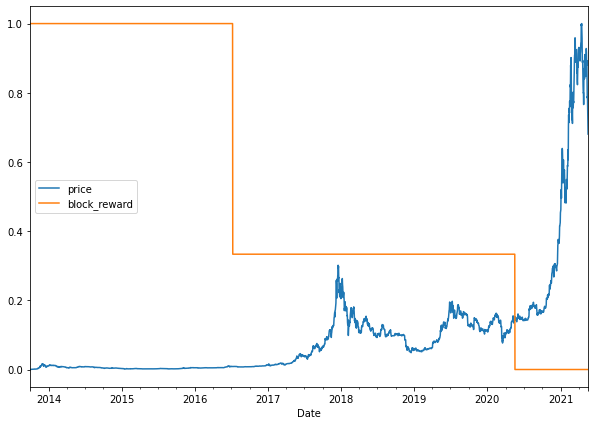

In [ ]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["price","block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10,7));

## Making a windowed dataset with Pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work. Not to worry, we have Pandas to help us through [`pandas.DataFrame.shift()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) method to window our multivariate data.

In [ ]:
# Setup data hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["price"].shift(periods=i+1)

In [ ]:
bitcoin_prices_windowed.head(10)

,price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]

```

In [ ]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: price, dtype: float32

In [ ]:
# Make train and test sets using indexing
split_size =  int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
X_train, y_train

(            block_reward      Price+1      Price+2      Price+3      Price+4  \
 Date                                                                           
 2013-10-08          25.0   121.794998   120.655327   121.338661   118.674660   
 2013-10-09          25.0   123.032997   121.794998   120.655327   121.338661   
 2013-10-10          25.0   124.049004   123.032997   121.794998   120.655327   
 2013-10-11          25.0   125.961159   124.049004   123.032997   121.794998   
 2013-10-12          25.0   125.279663   125.961159   124.049004   123.032997   
 ...                  ...          ...          ...          ...          ...   
 2019-11-05          12.5  9202.415039  9290.896484  9197.632812  9131.410156   
 2019-11-06          12.5  9369.627930  9202.415039  9290.896484  9197.632812   
 2019-11-07          12.5  9326.599609  9369.627930  9202.415039  9290.896484   
 2019-11-08          12.5  9335.751953  9326.599609  9369.627930  9202.415039   
 2019-11-09          12.5  9

## Model 6
Dense model, window size = 7, horizon = 1,
multivariate

In [ ]:
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(x=X_train,
            y=y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test,y_test),
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 4s - loss: 2377.1812
Epoch 1: val_loss improved from inf to 1474.05237, saving model to model_experiments/model_6_dense_multivariate
18/18 [==============================] - 1s 28ms/step - loss: 812.7720 - val_loss: 1474.0524
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 219.5167
Epoch 2: val_loss improved from 1474.05237 to 1106.78357, saving model to model_experiments/model_6_dense_multivariate
18/18 [==============================] - 0s 26ms/step - loss: 219.5167 - val_loss: 1106.7836
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 147.5238
Epoch 3: val_loss improved from 1106.78357 to 904.71448, saving model to model_experiments/model_6_dense_multivariate
18/18 [==============================] - 0s 24ms/step - loss: 164.7420 - val_loss: 904.7145
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 179.4613
Epoch 4: val_loss improved from 904.71448 to 767.69989, savi

In [ ]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 580.7388


580.73876953125

In [ ]:
# Load in and evaluate best performing model 6
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 566.3433


566.3433227539062

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8825.785, 8774.244, 9028.679, 8755.628, 8738.934, 8731.211,
       8652.222, 8542.193, 8431.968, 8521.517], dtype=float32)>

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 566.3433,
 'mape': 2.5429447,
 'mase': 0.99490833,
 'mse': 1160786.2,
 'rmse': 1077.398}

In [ ]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171743.8,
 'rmse': 1082.4711}

For a challenge on different ways to potentially improve the multivariate time series model, [see the reference](https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series): 


## Model 7: N-BEATS algorithm

We will build now the [N-BEATS algorithm](https://arxiv.org/abs/1905.10437). It is so far one of the most complex models we will build in this course.



### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we have to create it. To create custom layers and models in TensorFlow, we can use subclassing

In [ ]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of fully connected layers, each with ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")
  
  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

    return backcast, forecast

>**Note -** `**kwargs` or *keyword arguments* takes care of all the arguments for the parent class (input_shape, trainable, ... etc)

>**Note -** `super()` is a standard python method for instantiating classes

Now we are testing our N-BEATS block class. To do this, we'll make some dummy inputs and outputs

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be samesize as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+ 1, axis=0) 

>**Note -** Input shape to the model has to reflect dense layer input requirements (ndim=2)

In [ ]:
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
backcast, forecast

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[ 0.07960171,  0.32512033, -0.8428683 , -0.6938985 , -0.31720552,
         -0.5698734 , -0.6396662 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.0071648]], dtype=float32)>)

`backcast` and `forecast` are the activation outputs of the theta layer. They will be random due to no training of the model.

In [ ]:
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.07960171  0.32512033 -0.8428683  -0.6938985  -0.31720552 -0.5698734
 -0.6396662 ]
Forecast: 1.0071648359298706


### Preparing data for the N-BEATS algorithm using `tf.data` API

To make our input data load as fast as possible we are going to adhere to the [performant data pipeline steps](https://www.tensorflow.org/guide/data_performance) in tensorflow

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
BATCH_SIZE = 128

In [ ]:
# Create N-BEATS data inputs (N-BEATS worsk with univariate time series)
bitcoin_prices.head()

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"price+{i+1}"] = bitcoin_prices_nbeats["price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,price,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("price", axis=1)
y = bitcoin_prices_nbeats.dropna()["price"]

# Make train and test sets
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Now we make our dataset performant using `tf.data` API

In [ ]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

Combining labels and features by zipping the dataset together -> (features, labels)

In [ ]:
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

Finnally we batch and prefetch the dataset to make it performant:

In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

> **Note -** For recommended data performance, [revisit the recommendations by TensorFlow](https://www.tensorflow.org/guide/data_performance#best_practice_summary)

In [ ]:
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18, in https://arxiv.org/pdf/1905.10437.pdf

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for the residual connections

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections, see:
* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
* [Resnet on papers with code](https://paperswithcode.com/method/resnet)
* [Wikipedia on Residual Neural Networks](https://en.wikipedia.org/wiki/Residual_neural_network)

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# add 
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()}, & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")


Input tensors: [10 11 12 13 14 15 16 17 18 19], & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this will be the initial block used for the network, the rest will be created as parts of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers 
5. Use the `NBeatsBlock` within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses, but we will use MAE to keep it in line with our other models) and Adam optimizer with default settings as per section 5.2 in the paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping
  * Reduce LR on Plateau

In [ ]:
%%time

tf.random.set_seed(42)
# 1. Set up an instance of NBeatsBlock
nbeats_block_layers = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name="initial_block")


# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_inputs")

# 3. Create initial backcast and forecast (block 1 version)
backcast, forecast = nbeats_block_layers(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# first stack is created, so we decrease N_STACKS by 1
for i, _ in enumerate(range(N_STACKS -1)):
  
  # 5. Use the NBeatsBlcok to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # Pass in the residuals
  
  # 6. Create double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together 
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_nbeats")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 180: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 280: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 2min 15s, sys: 2.61 s, total: 2min 17s
Wall time: 2min 28s


In [ ]:
# Evaluate N-Beats model on the test dataset
model_7.evaluate(test_dataset)

5/5 [==============================] - 0s 9ms/step - loss: 565.8149


565.8148803710938

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8840.522, 8794.248, 9036.716, 8772.625, 8767.7  , 8755.234,
       8660.037, 8521.368, 8482.066, 8526.319], dtype=float32)>

In [ ]:
# Evaluate N_BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 565.8149,
 'mape': 2.581216,
 'mase': 0.99398005,
 'mse': 1149255.9,
 'rmse': 1072.0334}

In [ ]:
model_1_results, naive_results

({'mae': 568.9511,
  'mape': 2.5448983,
  'mase': 0.99948955,
  'mse': 1171743.8,
  'rmse': 1082.4711},
 {'mae': 567.9802,
  'mape': 2.516525,
  'mase': 0.99957,
  'mse': 1147547.0,
  'rmse': 1071.2362})

### Plotting the N-BEATS architecture we've created


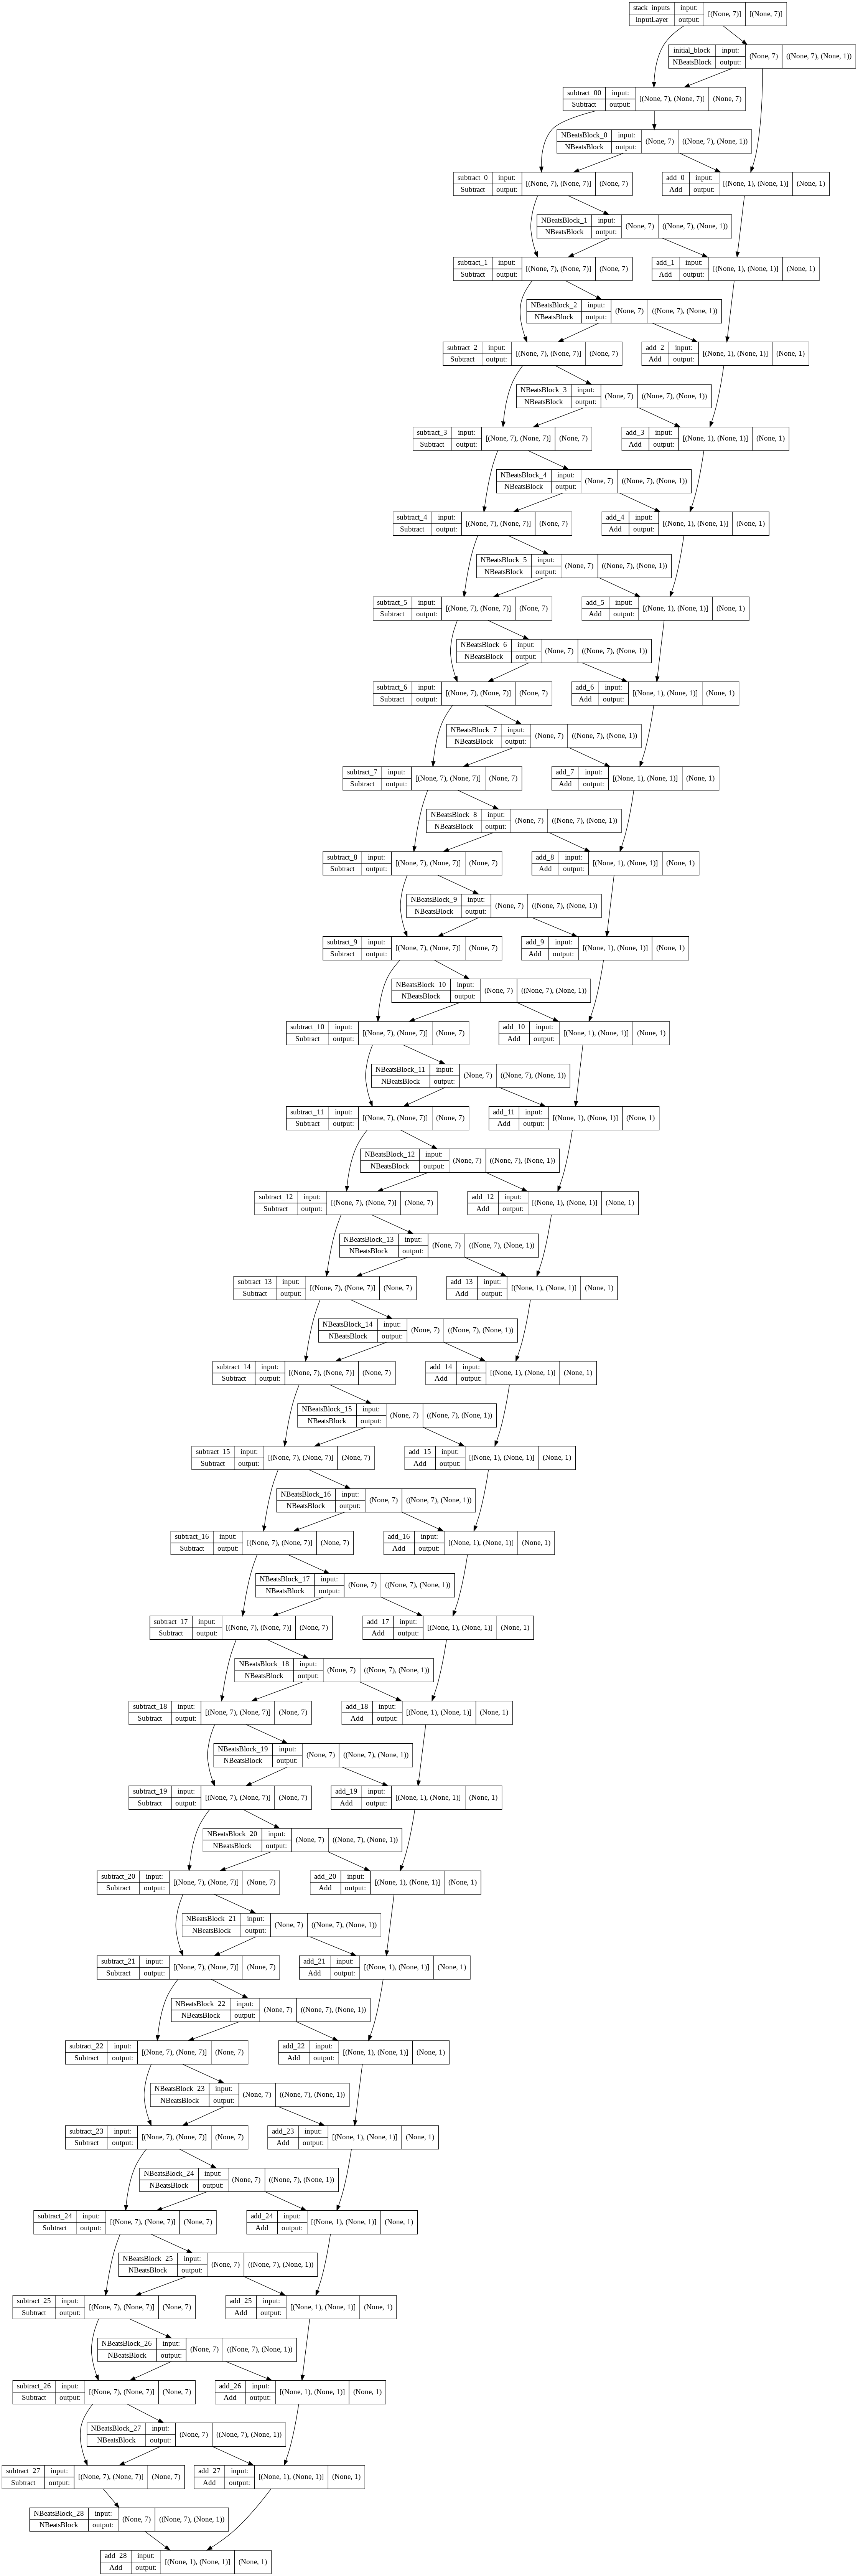

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model_7, show_shapes=True)

## Model 8: Create an Ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect. It combines many different models to predict a common goal.

In [ ]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae","mse","mape"]):
  """
  Returns a list of numiter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"])
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing {loss_function} for {num_epochs} epochs, model number: {i}")

      # construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          
          # Initialize dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing mae for 1000 epochs, model number: 0

Epoch 358: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 458: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mse for 1000 epochs, model number: 0

Epoch 595: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 695: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mape for 1000 epochs, model number: 0

Epoch 223: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 323: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mae for 1000 epochs, model number: 1

Epoch 196: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 320: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 420: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing mode

In [ ]:
len(ensemble_models)

15

In [ ]:
ensemble_models

In [ ]:
!nvidia-smi

Thu Oct  6 12:51:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    28W /  70W |   1836MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Make predictions with our ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions

def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)

ensemble_preds

CPU times: user 669 ms, sys: 39.8 ms, total: 709 ms
Wall time: 645 ms


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8798.534,  8799.444,  9040.786, ..., 49746.016, 48713.695,
        46056.805],
       [ 8796.677,  8700.322,  9003.968, ..., 49803.125, 48409.74 ,
        45871.684],
       [ 8760.594,  8746.833,  9087.299, ..., 50073.117, 47909.516,
        45625.477],
       ...,
       [ 8855.639,  8773.5  ,  9050.325, ..., 49261.664, 48622.875,
        45988.31 ],
       [ 8726.882,  8691.722,  9054.355, ..., 49580.164, 48277.55 ,
        46501.043],
       [ 8794.883,  8768.857,  9052.053, ..., 49756.383, 47856.805,
        45820.273]], dtype=float32)>

Our ensemble predictions come out in multiple dimensions but to combine into **point predictions** we can levarage descriptive statistical parameters such as mean or/and median 

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8796.3125, 8758.476 , 9044.777 , 8755.748 , 8743.11  , 8705.854 ,
       8662.372 , 8502.851 , 8432.993 , 8525.183 ], dtype=float32)>

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8796.677, 8768.857, 9047.699, 8751.672, 8746.385, 8718.779,
       8663.945, 8498.488, 8441.544, 8526.298], dtype=float32)

In [ ]:
# Evaluate our ensemble model predictions (mean)
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results


{'mae': 563.1609,
 'mape': 2.5557158,
 'mase': 0.9893177,
 'mse': 1137658.9,
 'rmse': 1066.611}

In [ ]:
# Evaluate our ensemble model predictions (median)
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 564.68146,
 'mape': 2.5581663,
 'mase': 0.9919889,
 'mse': 1141141.1,
 'rmse': 1068.2421}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models. E.g. horizon = 1, our model predicts one next timestamp price of Bitcoin

Wouldn't it be helpful if we knew a range of where that prediction came from? Instead of the estimated price on the point, how about a lower bound and an upper bound instead? That would give us an idea or more information of what our model is infering.

To get the 95% confidence prediction intervals for a deep learning model is the bootstrap method: 
1. Take the predictions from a number of randomly initialized models (we've got to this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is gaussian). This number refers to covering 95% of the area from the gaussian (normal) distribution $\pm 1.96 std$ from of the mean.
4. To get the prediction for upper and lower intervals, we have to add and substract the std from the mean. Sources about this are in [Uber's neural networks uncertainty estimation](https://eng.uber.com/neural-networks-uncertainty-estimation/) and [wikipedia's article on 1.96](https://en.wikipedia.org/wiki/1.96)


In [ ]:
ensemble_preds_std = tf.math.reduce_std(ensemble_preds, axis=0)
ensemble_preds_std[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([40.79724 , 39.606487, 25.416489, 34.876472, 26.340742, 38.793175,
       27.418713, 24.19862 , 29.367216, 16.354778], dtype=float32)>

In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds):
  """
    Takes the predictions from a number of randomly initialized models and
    outputs upper and lower limits 1.96 stds (95% of the data) fits within this range.
  """

  # Measure standard deviation
  std = tf.math.reduce_std(preds, axis=0)

  # Multiply the standard deviation by 1.96
  interval = std * 1.96

  # Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper


In [ ]:
# Get the upper and lower bounds of the 95% prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower, upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8716.35  ,  8680.847 ,  8994.961 ,  8687.391 ,  8691.482 ,
         8629.819 ,  8608.632 ,  8455.421 ,  8375.434 ,  8493.127 ,
         8170.6777,  8049.7407,  7981.8   ,  7573.8345,  7214.1895,
         7182.2837,  7021.699 ,  7148.069 ,  7079.983 ,  7449.5874,
         7391.062 ,  7675.825 ,  7549.169 ,  7337.8237,  7263.481 ,
         7250.086 ,  7186.8423,  7340.4575,  7489.143 ,  7533.4277,
         7519.9805,  7285.2593,  7177.491 ,  7136.1626,  7147.7803,
         7210.3813,  7050.0317,  7059.4805,  6829.4707,  6534.182 ,
         7227.0537,  7119.773 ,  7137.924 ,  7121.1836,  7173.4966,
         7163.7197,  7158.967 ,  7188.917 ,  7166.742 ,  7187.0386,
         7283.7217,  7373.5103,  7232.0464,  7130.652 ,  7123.828 ,
         6913.174 ,  7211.905 ,  7321.9917,  7342.4355,  7632.7173,
         8003.6235,  8102.8916,  7809.1553,  7981.958 ,  8072.2124,
         8142.5874,  8074.948 ,  8635.417 ,  8865.7   ,  8732.126 ,

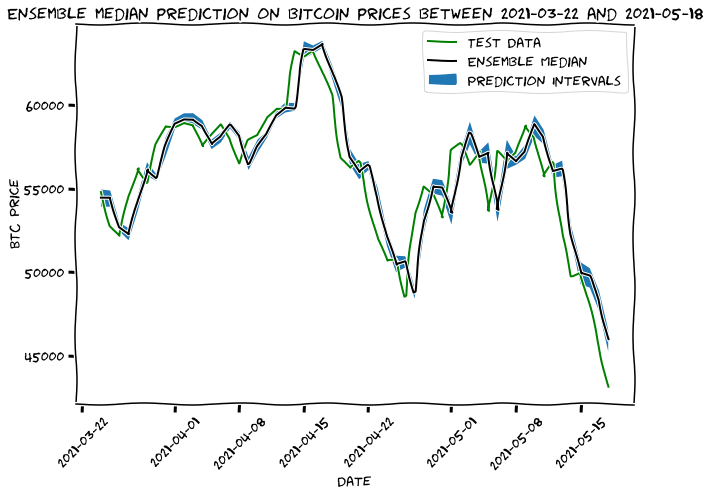

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals
offset=500

with plt.xkcd():
  plt.figure(figsize=(10,7))
  plt.plot(X_test.index[offset:], y_test[offset:], "g-", label="Test Data")
  plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
  plt.xlabel("Date")
  plt.ylabel("BTC Price")
  plt.xticks(rotation = 45)
  plt.title("Ensemble median prediction on bitcoin prices between 2021-03-22 and 2021-05-18")

  # To plot the upper and lower bound we use fill_between()
  plt.fill_between(X_test.index[offset:],
                  (lower)[offset:],
                  (upper)[offset:],
                  label="Prediction Intervals")
  plt.legend(loc="best", fontsize=14);

So far all of our model predictions have been lagging behind the test data. As in they are replicating what the naive modeldoes and just predicts the previous timestep as the next timestep.

>**Note -** These prediction intervals are estimates themselves and they have been created with the assumption that our model data is from a normal distribution

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know? (with perfect data, what's possible for our model to learn?)
2. What doesn't my model know. What can a model never predict? Or would it be helpful if a model could tell you that when making a prediction, it doesn't actually know if it's right or not?

There are two major types of uncertainty in machine learning we should know about:
* **Aleatoric uncertainty** (random, or stochastic): This type of uncertainty cannot be reduced, and it is often referred as data uncertainty or subway uncertainty.
* **Epistemic uncertainty** - this type of uncertainty can be reduced. It is also referred to as "model" or "coconut" uncertainty

## Model 9: Train a model on the full historical data to make preditions into the future

So far all of our models have predicted on the test dataset, however this is only a pseudofuture. Let's now build a model which is capable of predicting into the future!

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed.head()

,price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
bitcoin_prices_windowed.tail()

,price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["price", "block_reward"], axis=1).to_numpy()
# get labels
y_all = bitcoin_prices_windowed.dropna()["price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [ ]:
X_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

In [ ]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

# construct a simple model (similar to model_1)
model_9 = tf.keras.Sequential([
    
    # Initialize dense layers with normal distribution for estimating prediction intervals later on
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_9_future_model")

# Compile simple model with current loss function
model_9.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=0)


## Make predictions into the future

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14

To make predictions into the future we want a function which:
1. take as input:
  * A list of values (bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data (shape) it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it is full of predictions) and extracts the last `WINDOW_SIZE` values from the input values.
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE`sequences which updates to remove the first value and add the latest 

In [ ]:
def make_future_forecasts(data, model=model_9, into_future=INTO_FUTURE, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.
  Returns future forecasts as a list of floats.
  """  

  # 2. Create mepty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = y_all[-WINDOW_SIZE:]

  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again.
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n{last_window} -> prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast 



In [ ]:
future_forecast = make_future_forecasts(y_all, model_9)

Predicting on:
[56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> prediction: 55764.47265625

Predicting on:
[52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.47265625] -> prediction: 50985.9296875

Predicting on:
[49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.47265625 50985.9296875 ] -> prediction: 48522.9609375

Predicting on:
[50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.47265625 50985.9296875  48522.9609375 ] -> prediction: 48137.19921875

Predicting on:
[47885.62525472 45604.61575361 43144.47129086 55764.47265625
 50985.9296875  48522.9609375  48137.19921875] -> prediction: 47880.6328125

Predicting on:
[45604.61575361 43144.47129086 55764.47265625 50985.9296875
 48522.9609375  48137.19921875 47880.6328125 ] -> prediction: 46879.71484375

Predicting on:
[43144.47129086 55764.47265625 50985.9296875  48522.9609375
 4813

### Plot future forecasts

In [ ]:
len(future_forecast)

14

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date + into_future
  """
  # Specify start date and "D" stands for days
  start_date = start_date + np.timedelta64(offset, "D")

  # Specify end_date
  end_date = start_date + np.timedelta64(into_future, "D")

  # Return a date range between start_date and end_date
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [ ]:
last_timestep = bitcoin_prices.index[-1]

next_timesteps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_timesteps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

we'll nsert last timestep/final price into next time steps and future forecasts so the plot doesn't look disjointed

In [ ]:
next_timesteps = np.insert(next_timesteps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_timesteps, future_forecast

(array(['2021-05-18', '2021-05-18', '2021-05-19', '2021-05-20',
        '2021-05-21', '2021-05-22', '2021-05-23', '2021-05-24',
        '2021-05-25', '2021-05-26', '2021-05-27', '2021-05-28',
        '2021-05-29', '2021-05-30', '2021-05-31', '2021-06-01'],
       dtype='datetime64[D]'),
 array([43144.473, 43144.473, 55764.473, 50985.93 , 48522.96 , 48137.2  ,
        47880.633, 46879.715, 48227.594, 53963.684, 49685.543, 47596.176,
        48114.418, 48807.996, 48623.85 , 50178.715], dtype=float32))

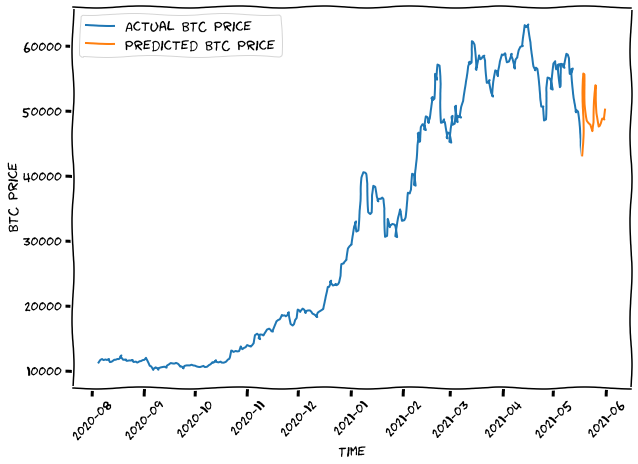

In [ ]:
# Plot future price predictions of Bitcoin
with plt.xkcd():
  plt.figure(figsize=(10,7))
  plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price");
  plot_time_series(next_timesteps, future_forecast, format="-", label="Predicted BTC Price")
  plt.xticks(rotation=45);

## Model 10: Why forecasting is bs (the turkey problem)

We'll introduce now a turkey problem to our BTC data (price of BTC falls 100x in one day)

In [ ]:
btc_price_turkey = btc_price.copy()

In [ ]:
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

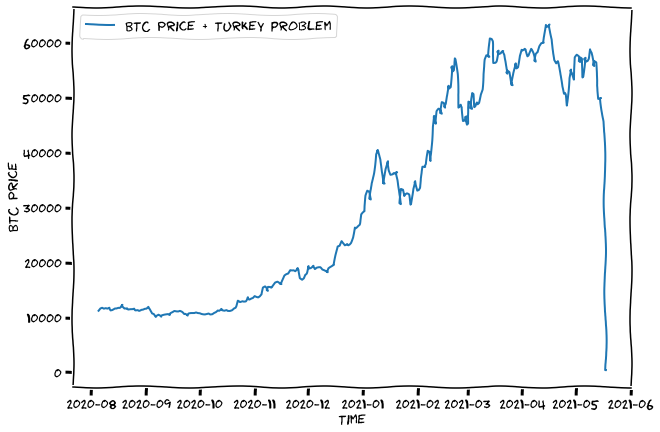

In [ ]:
with plt.xkcd():

  plt.figure(figsize=(10, 7))
  plot_time_series(timesteps=btc_timesteps_turkey,
                   values=btc_price_turkey,
                   format="-",
                   label="BTC Price + Turkey problem",
                   start=2500)

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey),
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)

In [ ]:
# 1. Construct model
model_10 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name = "model_10_turkey_model")


model_10.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam())
model_10.fit(x=X_train,
             y=y_train,
             epochs=100,
             validation_data=(X_test, y_test),
             verbose=0,
             callbacks=[create_model_checkpoint(model_10.name)])


Epoch 1: val_loss improved from inf to 1099.78040, saving model to model_experiments/model_10_turkey_model

Epoch 2: val_loss improved from 1099.78040 to 1006.83521, saving model to model_experiments/model_10_turkey_model

Epoch 3: val_loss improved from 1006.83521 to 930.02209, saving model to model_experiments/model_10_turkey_model

Epoch 4: val_loss improved from 930.02209 to 850.87463, saving model to model_experiments/model_10_turkey_model

Epoch 5: val_loss did not improve from 850.87463

Epoch 6: val_loss improved from 850.87463 to 767.30542, saving model to model_experiments/model_10_turkey_model

Epoch 7: val_loss improved from 767.30542 to 725.09930, saving model to model_experiments/model_10_turkey_model

Epoch 8: val_loss improved from 725.09930 to 703.42505, saving model to model_experiments/model_10_turkey_model

Epoch 9: val_loss did not improve from 703.42505

Epoch 10: val_loss did not improve from 703.42505

Epoch 11: val_loss did not improve from 703.42505

Epoch 12

In [ ]:
model_10.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 670.7973


670.7973022460938

In [ ]:
# Load in the best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 642.4382


642.4381713867188

In [ ]:
model_10_pred = turkey_model.predict(X_test)

In [ ]:
model_10_results = evaluate_preds(y_true=y_test,
                                     y_pred=tf.squeeze(model_10_pred))
model_10_results

{'mae': 17140.348,
 'mape': 121.50715,
 'mase': 26.524744,
 'mse': 615261700.0,
 'rmse': 23736.312}

In [ ]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171743.8,
 'rmse': 1082.4711}

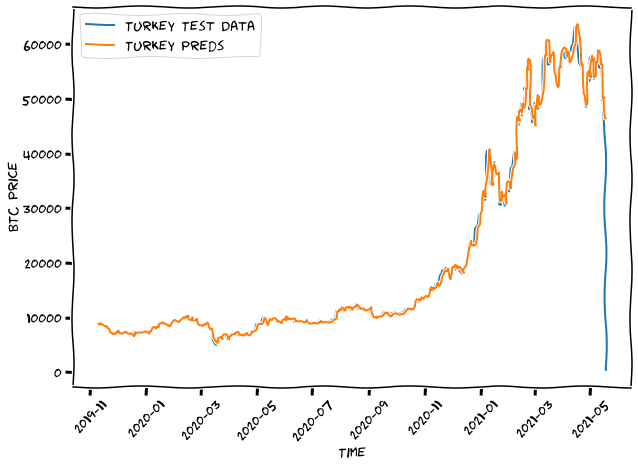

In [ ]:
with plt.xkcd():
  plt.figure(figsize=(10,7))
  offset=300
  plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                   values=btc_price_turkey[-len(y_test):],
                   format="-",
                   label="Turkey Test Data",
                   start=0)
  plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                   values=model_10_pred,
                   format="-",
                   start=0,
                   label="Turkey Preds")
  plt.xticks(rotation=45)

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": model_10_results}).transpose()

model_results

,mae,mape,mase,mse,rmse
naive_model,567.980225,2.516525,0.999570,1.147547e+06,1071.236206
model_1_dense_w7_h1,568.951111,2.544898,0.999490,1.171744e+06,1082.471069
model_2_dense_w30_h1,608.263672,2.754868,1.063251,1.268798e+06,1126.409424
model_3_dense_30_h7,1237.506348,5.558878,2.202073,5.405198e+06,1425.747681
model_4_CONV1D,563.979919,2.509260,0.990757,1.157844e+06,1076.031494
model_5_LSTM,594.602966,2.671757,1.044553,1.267232e+06,1125.713867
model_6_multivariate,566.343323,2.542945,0.994908,1.160786e+06,1077.397949
model_7_NBEATS,565.814880,2.581216,0.993980,1.149256e+06,1072.033447
model_8_ensemble,564.681458,2.558166,0.991989,1.141141e+06,1068.242065
model_10_turkey,17140.347656,121.507149,26.524744,6.152617e+08,23736.312500


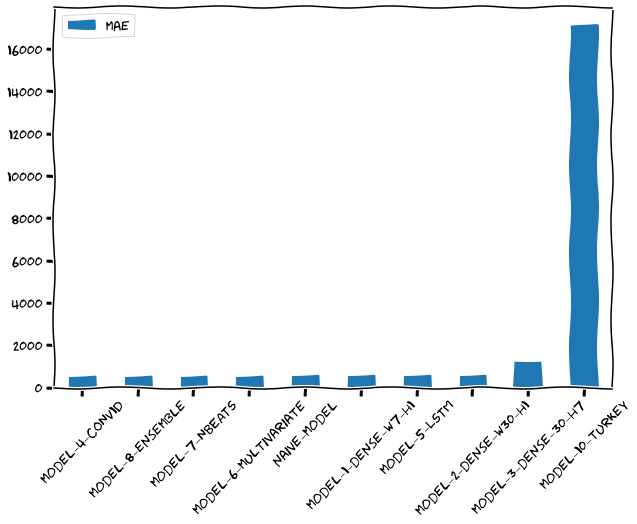

In [ ]:
# Sort model results by MAE and plot them
with plt.xkcd():
  model_results[["mae"]].sort_values(by="mae").plot(figsize=(10,7), kind="bar")
  plt.xticks(rotation=45)